Overall Center of Mass: [-0.00181745 -0.00108264 -0.28959802] R_E
Total mass: 3.06e+24 kg
Total Angular Momentum: [-3.02623079e+32 -1.39453121e+33  1.73506215e+34] kg·m²/s
Total Angular Momentum Magnitude: 1.74e+34 kg·m²/s
Target Angular Momentum: [-3.62578338e+31 -1.64923094e+32  4.59174689e+32] (mag: 4.89e+32)
Impactor Angular Momentum: [-2.66365246e+32 -1.22960812e+33  1.68914468e+34] (mag: 1.69e+34)


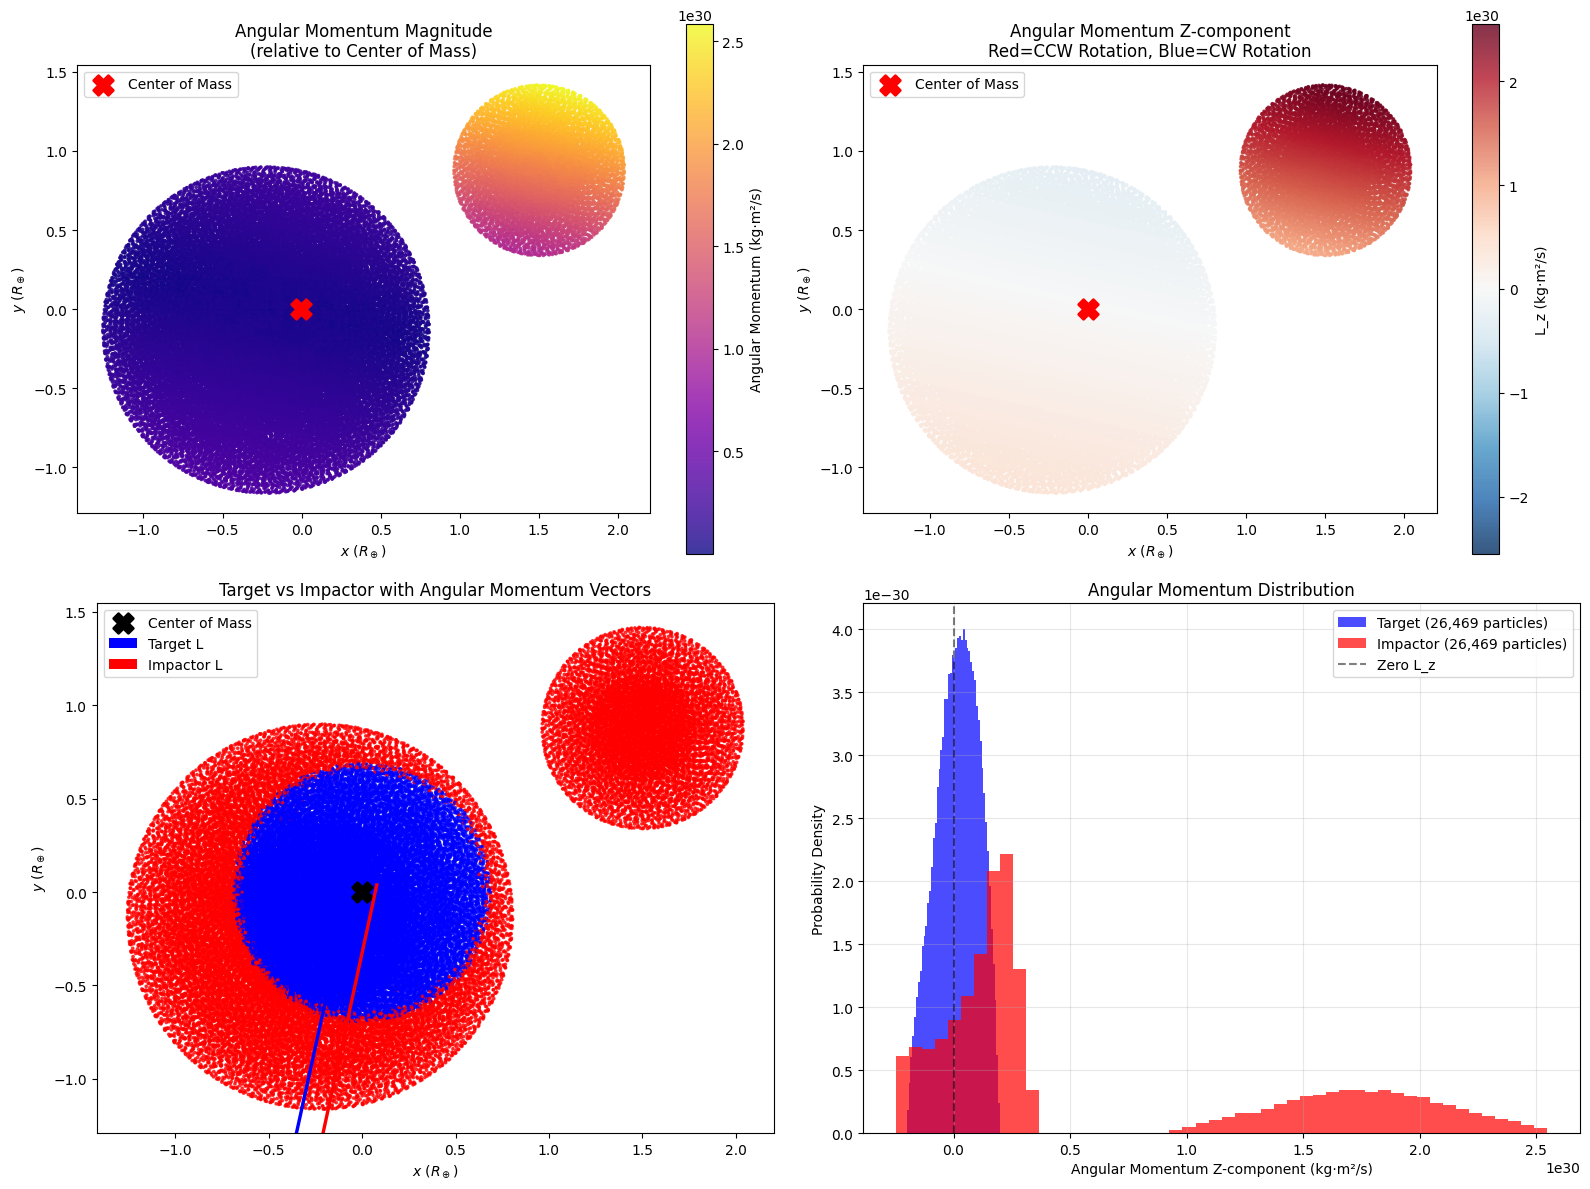


Detailed Angular Momentum Statistics:
Overall L_z: 1.74e+34 kg·m²/s
Target L_z: 4.59e+32 kg·m²/s
Impactor L_z: 1.69e+34 kg·m²/s
Sum of individual L_z: 1.74e+34 kg·m²/s

Target particles: 26,469
Impactor particles: 26,469


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import woma

def load_snapshot(filename):
    """Load and convert the particle data to plot."""
    with h5py.File(filename, "r") as f:
        # Units from file metadata
        file_to_SI = woma.Conversions(
            m=float(f["Units"].attrs["Unit mass in cgs (U_M)"]) * 1e-3,
            l=float(f["Units"].attrs["Unit length in cgs (U_L)"]) * 1e-2,
            t=float(f["Units"].attrs["Unit time in cgs (U_t)"]),
        )

        # Particle data
        A2_pos = (
            np.array(f["PartType0/Coordinates"][()])
            - 0.5 * f["Header"].attrs["BoxSize"]
        ) * file_to_SI.l
        A1_mat_id = np.array(f["PartType0/MaterialIDs"][()])
        A2_vel = np.array(f["PartType0/Velocities"][()]) * file_to_SI.v
        A1_m = np.array(f["PartType0/Masses"][()]) * file_to_SI.m

    # Restrict to z < 0 for plotting
    A1_sel = np.where(A2_pos[:, 2] < 0)[0]
    A2_pos = A2_pos[A1_sel]
    A1_mat_id = A1_mat_id[A1_sel]
    A2_vel = A2_vel[A1_sel]
    A1_m = A1_m[A1_sel]

    return A2_pos, A1_mat_id, A2_vel, A1_m

def calculate_bulk_properties(positions, velocities, masses, mask):
    """Calculate bulk properties for a group of particles using mass weighting."""
    if np.sum(mask) == 0:
        return None
    
    group_positions = positions[mask]
    group_velocities = velocities[mask]
    group_masses = masses[mask]
    
    total_mass = np.sum(group_masses)
    bulk_velocity = np.sum(group_velocities * group_masses[:, np.newaxis], axis=0) / total_mass
    center_of_mass = np.sum(group_positions * group_masses[:, np.newaxis], axis=0) / total_mass
    
    return {
        'bulk_velocity': bulk_velocity,
        'bulk_speed': np.linalg.norm(bulk_velocity),
        'center_of_mass': center_of_mass,
        'total_mass': total_mass,
        'n_particles': np.sum(mask)
    }

def separate_target_impactor(positions, masses):
    """Simple separation based on distance from center of mass."""
    com = np.sum(positions * masses[:, np.newaxis], axis=0) / np.sum(masses)
    distances = np.linalg.norm(positions - com, axis=1)
    median_dist = np.median(distances)
    target_mask = distances < median_dist
    impactor_mask = ~target_mask
    return target_mask, impactor_mask, com

# Load data
A2_pos, A1_mat_id, A2_vel, A1_m = load_snapshot("snapshots/demo_impact_n50_0000.hdf5")

# Earth units
R_E = 6.3710e6  # m

# Calculate overall center of mass
total_mass = np.sum(A1_m)
com_position = np.sum(A2_pos * A1_m[:, np.newaxis], axis=0) / total_mass

print(f"Overall Center of Mass: {com_position / R_E} R_E")
print(f"Total mass: {total_mass:.2e} kg")

# Calculate angular momentum for each particle relative to COM
positions_rel = A2_pos - com_position
angular_momentum = np.cross(positions_rel, A1_m[:, np.newaxis] * A2_vel)
angular_momentum_magnitude = np.linalg.norm(angular_momentum, axis=1)
angular_momentum_z = angular_momentum[:, 2]  # Z-component for 2D visualization

# Calculate total angular momentum
total_angular_momentum = np.sum(angular_momentum, axis=0)
total_angular_momentum_mag = np.linalg.norm(total_angular_momentum)

print(f"Total Angular Momentum: {total_angular_momentum} kg·m²/s")
print(f"Total Angular Momentum Magnitude: {total_angular_momentum_mag:.2e} kg·m²/s")

# Separate target and impactor
target_mask, impactor_mask, _ = separate_target_impactor(A2_pos, A1_m)

# Calculate angular momentum for each body
target_angular_momentum = np.sum(angular_momentum[target_mask], axis=0)
impactor_angular_momentum = np.sum(angular_momentum[impactor_mask], axis=0)

print(f"Target Angular Momentum: {target_angular_momentum} (mag: {np.linalg.norm(target_angular_momentum):.2e})")
print(f"Impactor Angular Momentum: {impactor_angular_momentum} (mag: {np.linalg.norm(impactor_angular_momentum):.2e})")

# Create comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Angular momentum magnitude
sc1 = ax1.scatter(A2_pos[:, 0] / R_E, A2_pos[:, 1] / R_E, 
                 c=angular_momentum_magnitude, cmap='plasma', 
                 s=3, alpha=0.8)
ax1.scatter(com_position[0] / R_E, com_position[1] / R_E, 
           c='red', s=200, marker='X', label='Center of Mass', linewidth=2)
ax1.set_xlabel(r'$x$ ($R_\oplus$)')
ax1.set_ylabel(r'$y$ ($R_\oplus$)')
ax1.set_title('Angular Momentum Magnitude\n(relative to Center of Mass)')
ax1.legend()
ax1.set_aspect('equal')
plt.colorbar(sc1, ax=ax1, label='Angular Momentum (kg·m²/s)')

# Plot 2: Angular momentum direction (Z-component)
vmax = np.max(np.abs(angular_momentum_z))
sc2 = ax2.scatter(A2_pos[:, 0] / R_E, A2_pos[:, 1] / R_E, 
                 c=angular_momentum_z, cmap='RdBu_r', 
                 s=3, alpha=0.8, vmin=-vmax, vmax=vmax)
ax2.scatter(com_position[0] / R_E, com_position[1] / R_E, 
           c='red', s=200, marker='X', label='Center of Mass', linewidth=2)
ax2.set_xlabel(r'$x$ ($R_\oplus$)')
ax2.set_ylabel(r'$y$ ($R_\oplus$)')
ax2.set_title('Angular Momentum Z-component\nRed=CCW Rotation, Blue=CW Rotation')
ax2.legend()
ax2.set_aspect('equal')
plt.colorbar(sc2, ax=ax2, label='L_z (kg·m²/s)')

# Plot 3: Target vs Impactor angular momentum
colors = np.where(target_mask, 'blue', 'red')
sc3 = ax3.scatter(A2_pos[:, 0] / R_E, A2_pos[:, 1] / R_E, 
                 c=colors, s=3, alpha=0.7)
ax3.scatter(com_position[0] / R_E, com_position[1] / R_E, 
           c='black', s=200, marker='X', label='Center of Mass', linewidth=2)

# Add angular momentum vectors for each body
target_com = np.sum(A2_pos[target_mask] * A1_m[target_mask, np.newaxis], axis=0) / np.sum(A1_m[target_mask])
impactor_com = np.sum(A2_pos[impactor_mask] * A1_m[impactor_mask, np.newaxis], axis=0) / np.sum(A1_m[impactor_mask])

# Scale vectors for visibility
scale = 1e-18
ax3.quiver(target_com[0] / R_E, target_com[1] / R_E, 
          target_angular_momentum[0] * scale, target_angular_momentum[1] * scale,
          color='blue', scale=1, scale_units='xy', width=0.005, label='Target L')
ax3.quiver(impactor_com[0] / R_E, impactor_com[1] / R_E, 
          impactor_angular_momentum[0] * scale, impactor_angular_momentum[1] * scale,
          color='red', scale=1, scale_units='xy', width=0.005, label='Impactor L')

ax3.set_xlabel(r'$x$ ($R_\oplus$)')
ax3.set_ylabel(r'$y$ ($R_\oplus$)')
ax3.set_title('Target vs Impactor with Angular Momentum Vectors')
ax3.legend()
ax3.set_aspect('equal')

# Plot 4: Angular momentum distribution
bins = 50
ax4.hist(angular_momentum_z[target_mask], bins=bins, alpha=0.7, 
        label=f'Target ({np.sum(target_mask):,} particles)', color='blue', density=True)
ax4.hist(angular_momentum_z[impactor_mask], bins=bins, alpha=0.7, 
        label=f'Impactor ({np.sum(impactor_mask):,} particles)', color='red', density=True)
ax4.axvline(x=0, color='black', linestyle='--', alpha=0.5, label='Zero L_z')
ax4.set_xlabel('Angular Momentum Z-component (kg·m²/s)')
ax4.set_ylabel('Probability Density')
ax4.set_title('Angular Momentum Distribution')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed statistics
print(f"\nDetailed Angular Momentum Statistics:")
print(f"Overall L_z: {total_angular_momentum[2]:.2e} kg·m²/s")
print(f"Target L_z: {target_angular_momentum[2]:.2e} kg·m²/s")
print(f"Impactor L_z: {impactor_angular_momentum[2]:.2e} kg·m²/s")
print(f"Sum of individual L_z: {target_angular_momentum[2] + impactor_angular_momentum[2]:.2e} kg·m²/s")

print(f"\nTarget particles: {np.sum(target_mask):,}")
print(f"Impactor particles: {np.sum(impactor_mask):,}")

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
import woma
from matplotlib.patches import Patch

# Plotting setup
plt.rcParams.update({
    "font.size": 12,
    "font.family": "serif",
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

# Earth units
R_E = 6.3710e6  # m

# Simulation parameters
SNAPSHOT_START = 0
SNAPSHOT_END = 27
SNAPSHOT_INTERVAL = 2000  # seconds between snapshots

def load_snapshot(filename):
    """Load and convert the particle data to plot."""
    with h5py.File(filename, "r") as f:
        # Units from file metadata
        file_to_SI = woma.Conversions(
            m=float(f["Units"].attrs["Unit mass in cgs (U_M)"]) * 1e-3,
            l=float(f["Units"].attrs["Unit length in cgs (U_L)"]) * 1e-2,
            t=float(f["Units"].attrs["Unit time in cgs (U_t)"]),
        )

        # Particle data
        A2_pos = (
            np.array(f["PartType0/Coordinates"][()])
            - 0.5 * f["Header"].attrs["BoxSize"]
        ) * file_to_SI.l
        A1_mat_id = np.array(f["PartType0/MaterialIDs"][()])
        
        # Load velocities
        A2_vel = np.array(f["PartType0/Velocities"][()]) * file_to_SI.v

        A1_m = np.array(f["PartType0/Masses"][()]) * file_to_SI.m

    # Restrict to z < 0 for plotting
    A1_sel = np.where(A2_pos[:, 2] < 0)[0]
    A2_pos = A2_pos[A1_sel]
    A1_mat_id = A1_mat_id[A1_sel]
    A2_vel = A2_vel[A1_sel]
    A1_m = A1_m[A1_sel]

    return A2_pos, A1_mat_id, A2_vel, A1_m

def separate_target_impactor(positions, velocities, material_ids, masses):
    """
    Separate target and impactor particles based on material IDs, positions, and masses.
    More robust separation using material distribution, spatial clustering, and mass information.
    """
    # Method 1: Use material ID distribution (if materials are different)
    unique_materials, material_counts = np.unique(material_ids, return_counts=True)
    
    if len(unique_materials) >= 2:
        # If we have at least 2 materials, assume they're distributed between bodies
        print(f"Materials found: {unique_materials} with counts: {material_counts}")
        
        # Calculate total mass for each material
        material_masses = []
        for mat_id in unique_materials:
            mat_mask = material_ids == mat_id
            total_mass = np.sum(masses[mat_mask])
            material_masses.append(total_mass)
        
        print(f"Material masses: {material_masses}")
        
        # Simple heuristic: larger mass group is target, smaller is impactor
        if material_masses[0] > material_masses[1]:
            target_mask = material_ids == unique_materials[0]
            impactor_mask = material_ids == unique_materials[1]
        else:
            target_mask = material_ids == unique_materials[1]
            impactor_mask = material_ids == unique_materials[0]
            
        print(f"Target mass: {np.sum(masses[target_mask]):.2e} kg")
        print(f"Impactor mass: {np.sum(masses[impactor_mask]):.2e} kg")
        
    else:
        # Method 2: Spatial separation based on density clustering with mass weighting
        print("Using spatial separation with mass weighting...")
        distances = np.linalg.norm(positions, axis=1)
        
        # Calculate center of mass
        total_mass = np.sum(masses)
        com_position = np.sum(positions * masses[:, np.newaxis], axis=0) / total_mass
        
        # Calculate distances from center of mass (more physically meaningful)
        distances_from_com = np.linalg.norm(positions - com_position, axis=1)
        
        # Find natural break in mass-weighted distance distribution
        hist, bin_edges = np.histogram(distances_from_com, bins=50, weights=masses)
        cumulative_mass = np.cumsum(hist) / np.sum(hist)
        
        # Find where cumulative mass distribution reaches ~50%
        split_index = np.argmax(cumulative_mass > 0.5)
        split_distance = bin_edges[split_index]
        
        target_mask = distances_from_com < split_distance
        impactor_mask = ~target_mask
        
        # Calculate masses for verification
        target_mass = np.sum(masses[target_mask])
        impactor_mass = np.sum(masses[impactor_mask])
        
        print(f"Target mass: {target_mass:.2e} kg ({target_mass/total_mass*100:.1f}%)")
        print(f"Impactor mass: {impactor_mass:.2e} kg ({impactor_mass/total_mass*100:.1f}%)")
        print(f"Separation distance: {split_distance:.2e} m")

# def separate_target_impactor(positions, velocities, material_ids):
#     """
#     Separate target and impactor particles based on material IDs and positions.
#     More robust separation using both material distribution and spatial clustering.
#     """
#     # Method 1: Use material ID distribution (if materials are different)
#     unique_materials, material_counts = np.unique(material_ids, return_counts=True)
    
#     if len(unique_materials) >= 2:
#         # If we have at least 2 materials, assume they're distributed between bodies
#         print(f"Materials found: {unique_materials} with counts: {material_counts}")
        
#         # Simple heuristic: larger group is target, smaller is impactor
#         if material_counts[0] > material_counts[1]:
#             target_mask = material_ids == unique_materials[0]
#             impactor_mask = material_ids == unique_materials[1]
#         else:
#             target_mask = material_ids == unique_materials[1]
#             impactor_mask = material_ids == unique_materials[0]
#     else:
#         # Method 2: Spatial separation based on density clustering
#         print("Using spatial separation...")
#         distances = np.linalg.norm(positions, axis=1)
        
#         # Find natural break in distance distribution
#         hist, bin_edges = np.histogram(distances, bins=50)
#         cumulative = np.cumsum(hist) / np.sum(hist)
        
#         # Find where cumulative distribution reaches ~50%
#         split_index = np.argmax(cumulative > 0.5)
#         split_distance = bin_edges[split_index]
        
#         target_mask = distances < split_distance
#         impactor_mask = ~target_mask
    
#     print(f"Target particles: {np.sum(target_mask)}")
#     print(f"Impactor particles: {np.sum(impactor_mask)}")
    
#     return target_mask, impactor_mask

def calculate_bulk_properties(positions, velocities, mask):
    """Calculate bulk properties for a group of particles."""
    if np.sum(mask) == 0:
        return None
    
    group_positions = positions[mask]
    group_velocities = velocities[mask]
    group_masses = masses[mask]
    
    # Bulk velocity
    bulk_velocity = np.sum(group_velocities * group_masses[:, np.newaxis], axis=0) / total_mass
    
    # Velocity dispersion
    velocity_dispersion = np.std(group_velocities, axis=0)
    dispersion_magnitude = np.linalg.norm(velocity_dispersion)
    
    # Center of mass
    total_mass = np.sum(group_masses)
    center_of_mass = np.sum(group_positions * group_masses[:, np.newaxis], axis=0) / total_mass
    
    return {
        'bulk_velocity': bulk_velocity,
        'bulk_speed': bnp.linalg.norm(bulk_velocity),
        'velocity_dispersion': velocity_dispersion,
        'dispersion_magnitude': dispersion_magnitude,
        'center_of_mass': center_of_mass,
        'n_particles': np.sum(mask),
        'total_mass': total_mass
    }

def calculate_simulation_time(snapshot_id):
    """Calculate simulation time for a given snapshot ID."""
    return SNAPSHOT_START + (snapshot_id * SNAPSHOT_INTERVAL)

def format_time(seconds):
    """Format time in seconds to a human-readable string."""
    hours = seconds / 3600
    minutes = (seconds % 3600) / 60
    secs = seconds % 60
    
    if hours >= 1:
        return f"{hours:.1f} h"
    elif minutes >= 1:
        return f"{minutes:.1f} min"
    else:
        return f"{secs:.0f} s"

def plot_velocity_analysis(A2_pos, A1_mat_id, A2_vel, A1_m, snapshot_id):
    """Create comprehensive velocity visualization for a single snapshot."""
    time = calculate_simulation_time(snapshot_id)
    time_str = format_time(time)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Impact Simulation - Time: {time_str} (Snapshot {snapshot_id})', fontsize=16)
    
    # Separate target and impactor
    target_mask, impactor_mask = separate_target_impactor(A2_pos, A2_vel, A1_mat_id)
    
    # Calculate bulk properties
    target_props = calculate_bulk_properties(A2_pos, A2_vel, target_mask)
    impactor_props = calculate_bulk_properties(A2_pos, A2_vel, impactor_mask)
    
    # Plot 1: Velocity magnitude scatter plot
    velocity_magnitudes = np.linalg.norm(A2_vel, axis=1)
    sc1 = axes[0,0].scatter(A2_pos[:,0] / R_E, A2_pos[:,1] / R_E, 
                           c=velocity_magnitudes, cmap='viridis', s=2, alpha=0.8)
    axes[0,0].set_xlabel('r"$x$ ($R_\oplus$)")')
    axes[0,0].set_ylabel('r"$y$ ($R_\oplus$)")')
    axes[0,0].set_title('Velocity Magnitude (m/s)')
    axes[0,0].set_aspect('equal')
    axes[0,0].grid(True, alpha=0.3)
    plt.colorbar(sc1, ax=axes[0,0], label='Velocity (m/s)')
    
    # Plot 2: Colour by material
    Di_mat_colour = {"ANEOS_Fe85Si15": "darkgray", "ANEOS_forsterite": "orangered"}
    Di_id_colour = {woma.Di_mat_id[mat]: colour for mat, colour in Di_mat_colour.items()}

    A1_colour = np.empty(len(A2_pos), dtype=object)
    for id_c, c in Di_id_colour.items():
        A1_colour[A1_mat_id == id_c] = c
    
    axes[0,1].set_aspect("equal")
    axes[0,1].scatter(
        A2_pos[:, 0] / R_E,
        A2_pos[:, 1] / R_E,
        c=A1_colour,
        edgecolors="none",
        marker=".",
        alpha=0.5,
    )
    # ax_lim = 10
    # axes[0,1].set_xlim(-ax_lim, ax_lim)
    # axes[0,1].set_ylim(-ax_lim, ax_lim)
    axes[0,1].set_xlabel(r"$x$ ($R_\oplus$)")
    axes[0,1].set_ylabel(r"$y$ ($R_\oplus$)")
    axes[0,1].set_title("Material Composition")
    axes[0,0].set_aspect('equal')
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 3: Velocity vectors (subsampled for clarity)
    subsample = slice(None, None, 50)  # Plot every 50th particle
    speed = np.linalg.norm(A2_vel[subsample], axis=1)
    quiver = axes[0,2].quiver(A2_pos[subsample,0] / R_E, A2_pos[subsample,1] / R_E,
                             A2_vel[subsample,0], A2_vel[subsample,1],
                             scale=1e4, color='red', alpha=0.6, width=0.003)
    axes[0,2].set_xlabel('X position ($R_\oplus$)')
    axes[0,2].set_ylabel('Y position ($R_\oplus$)')
    axes[0,2].set_title('Velocity Vectors (subsampled)')
    axes[0,2].set_aspect('equal')
    axes[0,2].grid(True, alpha=0.3)
    
    # Plot 4: Velocity distributions
    if np.sum(target_mask) > 0 and np.sum(impactor_mask) > 0:
        target_velocities = np.linalg.norm(A2_vel[target_mask], axis=1)
        impactor_velocities = np.linalg.norm(A2_vel[impactor_mask], axis=1)
        
        axes[1,0].hist(target_velocities, bins=30, alpha=0.7, label='Target', color='blue', density=True)
        axes[1,0].hist(impactor_velocities, bins=30, alpha=0.7, label='Impactor', color='red', density=True)
        axes[1,0].set_xlabel('Velocity Magnitude (m/s)')
        axes[1,0].set_ylabel('Probability Density')
        axes[1,0].set_title('Velocity Distribution')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
    
    # Plot 5: Velocity components distribution
    axes[1,1].hist(A2_vel[:,0], bins=30, alpha=0.7, label='Vx', color='orange', density=True)
    axes[1,1].hist(A2_vel[:,1], bins=30, alpha=0.7, label='Vy', color='green', density=True)
    axes[1,1].hist(A2_vel[:,2], bins=30, alpha=0.7, label='Vz', color='purple', density=True)
    axes[1,1].set_xlabel('Velocity Components (m/s)')
    axes[1,1].set_ylabel('Probability Density')
    axes[1,1].set_title('Velocity Components Distribution')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    # Plot 6: Bulk properties summary
    axes[1,2].axis('off')
    summary_text = []
    
    if target_props:
        summary_text.extend([
            "TARGET PROPERTIES:",
            f"Bulk speed: {target_props['bulk_speed']:.2f} m/s",
            f"Particles: {target_props['n_particles']}",
            f"Vel dispersion: {target_props['dispersion_magnitude']:.2f} m/s",
            f"Position: ({target_props['mean_position'][0]/R_E:.2f}, " +
                      f"{target_props['mean_position'][1]/R_E:.2f}) R⊕"
        ])
    
    if impactor_props:
        summary_text.extend([
            "",
            "IMPACTOR PROPERTIES:",
            f"Bulk speed: {impactor_props['bulk_speed']:.2f} m/s",
            f"Particles: {impactor_props['n_particles']}",
            f"Vel dispersion: {impactor_props['dispersion_magnitude']:.2f} m/s", 
            f"Position: ({impactor_props['mean_position'][0]/R_E:.2f}, " +
                      f"{impactor_props['mean_position'][1]/R_E:.2f}) R⊕"
        ])
    
    if target_props and impactor_props:
        relative_velocity = np.linalg.norm(target_props['bulk_velocity'] - impactor_props['bulk_velocity'])
        separation = np.linalg.norm(target_props['mean_position'] - impactor_props['mean_position'])
        summary_text.extend([
            "",
            "RELATIVE MOTION:",
            f"Relative speed: {relative_velocity:.2f} m/s",
            f"Separation: {separation/R_E:.2f} R⊕"
        ])
    
    if summary_text:
        axes[1,2].text(0.05, 0.95, '\n'.join(summary_text), transform=axes[1,2].transAxes,
                      fontfamily='monospace', fontsize=10, verticalalignment='top',
                      bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))
    
    plt.tight_layout()
    return fig, target_props, impactor_props

def analyze_velocity_evolution():
    """Analyze velocity evolution across all snapshots."""
    # Storage for time evolution data
    time_series = {
        'times': [],
        'target_bulk_speed': [],
        'impactor_bulk_speed': [], 
        'relative_speed': [],
        'target_dispersion': [],
        'impactor_dispersion': [],
        'separation': []
    }
    
    output_dir = "velocity_analysis"
    os.makedirs(output_dir, exist_ok=True)
    
    print("Starting velocity evolution analysis...")
    print("=" * 60)
    
    for snapshot_id in range(SNAPSHOT_END + 1):
        filename = f"snapshots/demo_impact_n50_{snapshot_id:04d}.hdf5"
        time = calculate_simulation_time(snapshot_id)
        
        if not os.path.exists(filename):
            print(f"Snapshot {snapshot_id:02d} not found: {filename}")
            continue
            
        print(f"Processing snapshot {snapshot_id:02d}, time = {format_time(time)}")
        
        try:
            # Load data using your function
            A2_pos, A1_mat_id, A2_vel = load_snapshot(filename)
            
            # Create individual snapshot analysis
            fig, target_props, impactor_props = plot_velocity_analysis(
                A2_pos, A1_mat_id, A2_vel, snapshot_id
            )
            
            # Save individual snapshot
            plt.savefig(f"{output_dir}/velocity_snapshot_{snapshot_id:04d}.png", 
                       dpi=150, bbox_inches='tight')
            plt.close()
            
            # Store time series data
            if target_props and impactor_props:
                time_series['times'].append(time)
                time_series['target_bulk_speed'].append(target_props['bulk_speed'])
                time_series['impactor_bulk_speed'].append(impactor_props['bulk_speed'])
                
                relative_velocity = np.linalg.norm(
                    target_props['bulk_velocity'] - impactor_props['bulk_velocity']
                )
                time_series['relative_speed'].append(relative_velocity)
                
                time_series['target_dispersion'].append(target_props['dispersion_magnitude'])
                time_series['impactor_dispersion'].append(impactor_props['dispersion_magnitude'])
                
                separation = np.linalg.norm(
                    target_props['mean_position'] - impactor_props['mean_position']
                )
                time_series['separation'].append(separation / R_E)
                
                print(f"  ✓ Target: {target_props['bulk_speed']:.1f} m/s, " +
                      f"Impactor: {impactor_props['bulk_speed']:.1f} m/s, " +
                      f"Relative: {relative_velocity:.1f} m/s")
            else:
                print(f"  ⚠ Could not separate bodies properly")
                
        except Exception as e:
            print(f"  ✗ Error processing snapshot {snapshot_id}: {e}")
            continue
    
    # Create time evolution summary plot
    if time_series['times']:
        print(f"\nCreating time evolution plots...")
        create_evolution_plots(time_series, output_dir)
    
    print("=" * 60)
    print(f"Analysis complete! Results saved to: {output_dir}/")

def create_evolution_plots(time_series, output_dir):
    """Create comprehensive time evolution plots."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Impact Simulation - Velocity Evolution', fontsize=16)
    
    times = np.array(time_series['times'])
    
    # Plot 1: Bulk speeds evolution
    axes[0,0].plot(times, time_series['target_bulk_speed'], 'b-', 
                  label='Target', linewidth=2.5, marker='o', markersize=4)
    axes[0,0].plot(times, time_series['impactor_bulk_speed'], 'r-', 
                  label='Impactor', linewidth=2.5, marker='s', markersize=4)
    axes[0,0].set_xlabel('Time (s)')
    axes[0,0].set_ylabel('Bulk Speed (m/s)')
    axes[0,0].set_title('Bulk Speeds Evolution')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Relative speed and separation
    ax2 = axes[0,1]
    color = 'green'
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Relative Speed (m/s)', color=color)
    ax2.plot(times, time_series['relative_speed'], color=color, 
            linewidth=2.5, marker='^', markersize=4)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.grid(True, alpha=0.3)
    
    ax2_twin = ax2.twinx()
    color = 'purple'
    ax2_twin.set_ylabel('Separation (R⊕)', color=color)
    ax2_twin.plot(times, time_series['separation'], color=color, 
                 linewidth=2.5, linestyle='--', marker='d', markersize=4)
    ax2_twin.tick_params(axis='y', labelcolor=color)
    
    axes[0,1].set_title('Relative Motion')
    
    # Plot 3: Velocity dispersions
    axes[1,0].plot(times, time_series['target_dispersion'], 'b--', 
                  label='Target dispersion', linewidth=2, marker='o', markersize=3)
    axes[1,0].plot(times, time_series['impactor_dispersion'], 'r--', 
                  label='Impactor dispersion', linewidth=2, marker='s', markersize=3)
    axes[1,0].set_xlabel('Time (s)')
    axes[1,0].set_ylabel('Velocity Dispersion (m/s)')
    axes[1,0].set_title('Internal Velocity Dispersions')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: Speed ratios and trends
    speed_ratio = np.array(time_series['impactor_bulk_speed']) / np.array(time_series['target_bulk_speed'])
    axes[1,1].plot(times, speed_ratio, 'purple', linewidth=2.5, marker='*', markersize=5)
    axes[1,1].axhline(y=1.0, color='gray', linestyle=':', alpha=0.7, label='Equal speed')
    axes[1,1].set_xlabel('Time (s)')
    axes[1,1].set_ylabel('Speed Ratio (Impactor/Target)')
    axes[1,1].set_title('Speed Ratio Evolution')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/velocity_evolution_summary.png", dpi=150, bbox_inches='tight')
    plt.close()
    
    print(f"✓ Evolution plots saved to {output_dir}/velocity_evolution_summary.png")

if __name__ == "__main__":
    # Test with a single snapshot first
    test_snapshot = 0
    test_filename = f"snapshots/demo_impact_n50_{test_snapshot:04d}.hdf5"
    
    if os.path.exists(test_filename):
        print("Testing with single snapshot...")
        A2_pos, A1_mat_id, A2_vel = load_snapshot(test_filename)
        fig, _, _ = plot_velocity_analysis(A2_pos, A1_mat_id, A2_vel, test_snapshot)
        plt.savefig("test_velocity_analysis.png", dpi=150, bbox_inches='tight')
        plt.close()
        print("✓ Test analysis saved as test_velocity_analysis.png")
    
    # Run full analysis
    analyze_velocity_evolution()

Testing with single snapshot...


ValueError: too many values to unpack (expected 3)